In [1]:
#load in the libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, plot_partial_dependence
from matplotlib.pyplot import figure
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from statistics import mean
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from nested_cv import NestedCV
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.inspection import PartialDependenceDisplay
import pickle

#ignore warnings if you want
import warnings
warnings.filterwarnings("ignore")

In [2]:
#make function to match the status for what ever parasite it is, binarize it, and drop unnecessary columns
def gettrain(df, parasite):
    #matching the sandfly status for the species of parasite to the sandfly in the larger dataframe
    for j in range(len(df)):
        for i in range(len(status)):
            if df.loc[j, 'species'] == status.loc[i, 'species']:
                df.loc[j, parasite] = status.loc[i, parasite]
    #fill the remaining vector status column with 0s, then binarize the status
    df[parasite] = df[parasite].fillna(0).map(lambda x : x//2)
    #set the index as the species name
    train = df.set_index('species')
    #drop unnecessary columns
    train = train.drop(columns=['Unnamed: 0', '.imp', '.id'])
    if 'index' in df.columns:
        train = train.drop(columns=['index'])
    
    return train

In [3]:
#code taken from https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d
#use the bootstrap methos to make make a confidence interval
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

# print the averages and the confidence interval
def getconf_interval(data):
    # Draw 15000 bootstrap replicates
    bs_replicates_aucs = draw_bs_replicates(data,np.mean,15000)

    # Print empirical mean
    print("Empirical mean: " + str(round(np.mean(data), 3)))

    # Print the mean of bootstrap replicates
    print("Bootstrap replicates mean: " + str(round(np.mean(bs_replicates_aucs), 3)))

    # Get the corresponding values of 2.5th and 97.5th percentiles
    conf_interval = np.percentile(bs_replicates_aucs,[2.5,97.5])

    # Print the interval
    print("The confidence interval: ", np.round(conf_interval, 3))


# return the confidence interval
def getconf_interval_var(data):
    # Draw 15000 bootstrap replicates
    bs_replicates_aucs = draw_bs_replicates(data,np.mean,15000)

    # Get the corresponding values of 2.5th and 97.5th percentiles
    conf_interval = np.percentile(bs_replicates_aucs,[2.5,97.5])
    
    return conf_interval

#get imp100, a dataframe of the variable importances across the ten models
def fscore(list_of_models):
    #takes in modelslist created in the predtable function
    #make a list of the most important variables for each model
    importancelist = []
    for x in range(100):
        importancelist.append(pd.DataFrame(list_of_models[x].get_booster().get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False))

    #make a dataframe of all the dataframes in importancelist
    imp100 = pd.DataFrame()
    for i in range(100):
        imp100 = imp100.append(importancelist[i], ignore_index = True)
                
    return imp100

#takes in modelslist created in the predtable function
def var_impt(list_of_models):

    #add the importances of each feature and arrange them in decreasing order
    mean = fscore(list_of_models).groupby('feature').mean().sort_values(by='importance', ascending=False).reset_index()
    std = fscore(list_of_models).groupby('feature').std().sort_values(by='importance', ascending=False).reset_index()
    count = pd.DataFrame(fscore(list_of_models)['feature'].value_counts()).reset_index()

    #get std into dataframes
    for x in range(len(mean)):
        for y in range(len(std)):
            if mean.loc[x, 'feature'] == std.loc[y, 'feature']:
                mean.loc[x, 'std'] = std.loc[y, 'importance']
        #get count of variables
        for z in range(len(count)):
            if mean.loc[x, 'feature'] == count.loc[z, 'index']:
                mean.loc[x, 'count'] = count.loc[z, 'feature'] 
                
    return mean.round(3)

In [4]:
def getstatus(df, parasite):
    for i in range(len(status)):
        for j in range(len(df)):
            if status.loc[i, 'species'] == df.loc[j, 'species']:
                df.loc[j, 'potential/proven'] = status.loc[i, parasite]
    df = df.fillna(0)
    return df

In [5]:
original = pd.read_csv('raw data/one hot encoded original data.csv')
original = original.drop(columns=['Argentina', 'Belize','Bolivia', 'Brazil', 'Canada', 'CaymanIslands', 'Chile', 'Colombia', 'Costa.Rica', 'Cuba', 'Dominican.Republic', 'Ecuador', 'El.Salvador', 'French.Guiana','Guadeloupe', 'Guatemala', 'Grenada', 'Guyana', 'Haiti', 'Honduras', 'Jamaica','Martinica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay','PuertoRico', 'Peru', 'Suriname', 'TrinidadTobago', 'Uruguay', 'USA', 'Venezuela','VirginIslands'])
status = pd.read_csv('raw data/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 1

#get cleaned train datasets in a list
parasite = 'leish'
for j in range(len(original)):
    for i in range(len(status)):
        if original.loc[j, 'species'] == status.loc[i, 'species']:
            original.loc[j, parasite] = status.loc[i, parasite]

#fill the remaining vector status column with 0s, then binarize the status
original[parasite] = original[parasite].fillna(0).map(lambda x : x//2)
#set the index as the species name
original = original.set_index('species')
#drop unnecessary columns
original_clean = original.drop(columns=['Unnamed: 0'])

####LOOK AT CORRELLATED VARIABLES
#tribe_Hertigiini is corr w 'genus_Warileya'
#subtribe_hertigiina is corr w 'genus_Warileya'
#peri is corr w semi.domestic
#'genus_Brumptomyia' is corr w 'subtribe_Brumptomyiina'
#'genus_Micropygomyia' is corr w 'subtribe_Sergentomyiina'

#wing_width / hs.canopy
#wing_width / hs.floor
#labruml_wingl / log.labrum.length
#log.grass.cover / log.shrub.cover
#domestic / intra
#wing.width/temp 
#log.elevation / temp
#log.temp.var / temp.range
#maxshape_sabre / genus_Brumptomyia
#log.dental.depth / log.labrum.length


# pd.DataFrame(original_clean.corr()).to_csv('correllation.csv')
original_clean = original_clean.drop(columns=['subtribe_Sergentomyiina', 'subtribe_Brumptomyiina',
                                              'peri', 'subtribe_Hertigiina', 'tribe_Hertigiini',
                                              'wing.width', 'labruml_wingl', 'log.shrub.cover',
                                              'intra', 'log.elevation', 'log.temp.var', 'maxshape_sabre', 'log.dental.depth'])

In [86]:
#look at a correlation matrix and find a trait that closely resembles the bites.man trait
corr = original_clean.corr()
corr.sort_values(by='log.labrum.length', ascending=False)['log.labrum.length'].head(6)
#bites.man is correlated with log.labrum.length by 0.623

log.labrum.length          1.000000
bites.man                  0.623070
no.lat.teeth               0.434623
wing.length                0.407223
subtribe_Psychodopygina    0.355116
bites.mammals              0.347184
Name: log.labrum.length, dtype: float64

In [6]:
#REMOVE THE BITES MAN COLUMN FOR THE MOST CONSERVATIVE ANALYSIS
original_clean = original_clean.drop(columns=['bites.man'])

In [12]:
#check the coverage of the traits: we should have no traits below 10 percent coverage
coverage = 1-original_clean.isna().sum()/512

c = pd.DataFrame(coverage)
c[c[0] < 0.11]

# citation prediction

In [7]:
#rearrange so that we predict citations, rather than vector status
data_c = original_clean.iloc[:,:-1].drop(columns = ['log.citations'])
c = original_clean.iloc[:,:-1]['log.citations']
data_c['log.citations'] = c

In [14]:
data_c.to_csv('citation model/citation data.csv')

In [25]:
#####code taken from https://www.kaggle.com/felipefiorini/xgboost-hyper-parameter-tuning

def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.02, 0.04, 0.06, 0.08, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5, 7, 9, 11],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6],
        'n_estimators' : [100, 300, 500, 600],
        'alpha' : [0.05, 0.1, 0.2, 0.3, 0.5],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 2,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [11]:
data = data_c
X, y = data.iloc[:,:-1],data.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
kf = KFold(n_splits=10, shuffle=True)

In [27]:
list_params = []
for x in range(1):
    best_params = hyperParameterTuning(X_train, y_train)
    list_params.append(best_params)

Fitting 2 folds for each of 12000 candidates, totalling 24000 fits


In [30]:
#make a pkl file to store these parameters
import pickle
# create a binary pickle file 
f = open("citation model/citation parameters.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(list_params,f)

# close file
f.close()

In [8]:
citation_params = pd.read_pickle(r'citation model/citation parameters.pkl')

In [33]:
citation_params

[{'alpha': 0.5,
  'colsample_bytree': 0.6,
  'learning_rate': 0.04,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 100,
  'objective': 'reg:squarederror',
  'subsample': 0.7}]

In [9]:
xgb_model = XGBRegressor(**citation_params[0])

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

In [41]:
#k fold r^2 scores
from sklearn.metrics import r2_score
kfold = KFold(n_splits=10, shuffle=True)
print(mean(cross_val_score(xgb_model, X, y, scoring='r2', cv=kfold)))

0.17933930334259093


In [36]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_xgb)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))


MSE: 16.57
RMSE: 4.07


In [37]:
#gaussian distribution

print(xgb_model.score(X_train,y_train)) # auc score
print(mae_xgb) #mean error

0.4397887328464468
3.6436914437496486


C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [39]:
#get variable importance
['weight', 'gain', 'cover', 'total_gain', 'total_cover']
importance = xgb_model.get_booster().get_score(importance_type='weight')

In [59]:
vi = sorted(importance.items(),key= lambda x:x[1], reverse = True)
vi = pd.DataFrame(vi)
vi.rename(columns = {0:'feature', 1:'importance'}, inplace = True)
vi.to_csv("citation model/citation var impt.csv")

In [18]:
vi = pd.read_csv("citation model/citation var impt.csv")

In [19]:
sum = vi['importance'].sum()
vi['importance'] = vi['importance']/sum
vi = round(vi, 3)

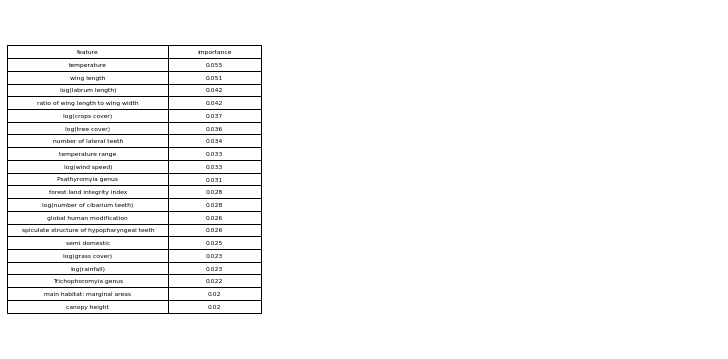

In [20]:
from matplotlib.backends.backend_pdf import PdfPages
fig, ax =plt.subplots(figsize=(8,6))
# ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=vi.head(20).values,colLabels=vi.head(20).columns,loc='left', cellLoc = 'center', colWidths=[0.35, 0.2, 0.1])

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("citation model/citation var impt.pdf")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
pp.savefig(fig, bbox_inches='tight')
pp.close()

# target shuffling

In [65]:
data = original_clean.reset_index()
data['leish'] = 0
l = data[['species', 'leish']]

In [66]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
    
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

target_shuffle = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        target_shuffle.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here

In [69]:
#do shuffling and nested cv
target_shuffle = []
for i in range(50):
    data = original_clean.reset_index()
    l = data[['species', 'leish']]
    #shuffle leish column
    shuffle = pd.DataFrame(l.sample(frac = 0.078))
    data['leish'] = 0
    for j in range(len(data)):
        for i in range(len(shuffle)):
            if data.loc[j, 'species'] == shuffle.reset_index().loc[i, 'species']:
                data.loc[j, 'leish'] = 1
    data = data.set_index('species')
    do_nested_cv(data)

100%|██████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26trial/s, best loss: 0.4821428571428572]
Final Test Score is 0.5032894736842105
best = {'a': 0, 'colsample_bytree': 0.6172491296937691, 'gamma': 11.638498784657944, 'learning_rate': 0.5498873472195474, 'max_depth': 6.397435590373344, 'n_estimators': 170.82334305115663, 'scale_pos_weight': 3.848025677401031}
100%|█████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41trial/s, best loss: 0.5]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.9988223931682458, 'gamma': 30.515187264769796, 'learning_rate': 0.24370004455860406, 'max_depth': 4.310614928845627, 'n_estimators': 114.20321559133657, 'scale_pos_weight': 0.5913849071609906}
100%|█████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.33trial/s, best loss: 0.5]
Final Test Score is 0.5381578947368422
best = {'a': 0, 'colsample_bytree': 0.8477385774448157, 'gamma': 13.7212054657

100%|█████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36trial/s, best loss: 0.5]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.9492101971264757, 'gamma': 780.9614969801604, 'learning_rate': 0.2985845716448996, 'max_depth': 9.941184847203719, 'n_estimators': 100.36854278882352, 'scale_pos_weight': 8.044670314190281}
100%|█████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35trial/s, best loss: 0.44047619047619047]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.3892392062704292, 'gamma': 552.895598288218, 'learning_rate': 0.6280497352200505, 'max_depth': 1.4677302120278757, 'n_estimators': 131.3662361343985, 'scale_pos_weight': 2.277164304294319}
100%|█████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39trial/s, best loss: 0.5]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.2004449791031382, 'gamma': 725.2303805029063, 'learning_rate': 0.8810591964

In [70]:
np.mean([target_shuffle[x][1] for x in range(50)])

0.4947261760461761

# primary model

### cross validation

In [73]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', objective = 'binary:logistic', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > np.mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
    
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

primary_parameters = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params, objective='binary:logistic')
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        primary_parameters.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here
    


In [74]:
### get out a list *primary_parameters* that has the parameters and aucs

for i in range(100):
    data = original_clean
    do_nested_cv(data)

100%|█████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34trial/s, best loss: 0.11076097105508868]
Final Test Score is 0.7254464285714286
best = {'a': 0, 'colsample_bytree': 0.5779741702674291, 'gamma': 55.67832707457921, 'learning_rate': 0.5945601154755449, 'max_depth': 9.154447834024998, 'n_estimators': 157.83567376563641, 'scale_pos_weight': 14.28732656108653}
100%|█████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37trial/s, best loss: 0.16232492997198877]
Final Test Score is 0.8087797619047619
best = {'a': 0, 'colsample_bytree': 0.26927854787555255, 'gamma': 11.743741007816823, 'learning_rate': 0.27104967523161216, 'max_depth': 4.127060768301112, 'n_estimators': 132.96145468283552, 'scale_pos_weight': 14.981911692632938}
100%|█████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38trial/s, best loss: 0.18639122315592904]
Final Test Score is 0.8035714285714285
best = {'a': 0, 'colsample_bytree': 0.25883552793606124, 'gamma

100%|█████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36trial/s, best loss: 0.17243230625583564]
Final Test Score is 0.8296130952380953
best = {'a': 0, 'colsample_bytree': 0.8847616600729681, 'gamma': 10.59020432481092, 'learning_rate': 0.30036262614818326, 'max_depth': 4.5313581704660955, 'n_estimators': 138.51346404829872, 'scale_pos_weight': 9.902232807167522}
100%|████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26trial/s, best loss: 0.13062558356676]
Final Test Score is 0.7061011904761906
best = {'a': 0, 'colsample_bytree': 0.20935548101651624, 'gamma': 19.071478163972618, 'learning_rate': 0.153623864780932, 'max_depth': 9.483533956377185, 'n_estimators': 196.89712987325345, 'scale_pos_weight': 14.807069775776828}
100%|█████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38trial/s, best loss: 0.21216153127917828]
Final Test Score is 0.7723214285714286
best = {'a': 0, 'colsample_bytree': 0.6876559102629001, 'gamma'

100%|█████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32trial/s, best loss: 0.15662931839402428]
Final Test Score is 0.7165178571428572
best = {'a': 0, 'colsample_bytree': 0.27614311075254133, 'gamma': 14.088068391551447, 'learning_rate': 0.5220249352377931, 'max_depth': 7.499620791608212, 'n_estimators': 125.23685435088558, 'scale_pos_weight': 9.487555278277345}
100%|██████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17trial/s, best loss: 0.1724089635854342]
Final Test Score is 0.8489583333333334
best = {'a': 0, 'colsample_bytree': 0.219427786587021, 'gamma': 20.95988073566334, 'learning_rate': 0.34963603201829296, 'max_depth': 9.81640810371285, 'n_estimators': 174.2587816281865, 'scale_pos_weight': 10.099354729168432}
100%|█████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16trial/s, best loss: 0.19225023342670397]
Final Test Score is 0.8177083333333334
best = {'a': 0, 'colsample_bytree': 0.8725086007314677, 'gamma': 6

100%|██████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31trial/s, best loss: 0.1722222222222222]
Final Test Score is 0.8400297619047619
best = {'a': 0, 'colsample_bytree': 0.8278980731377823, 'gamma': 69.1335321464839, 'learning_rate': 0.9092590617171998, 'max_depth': 4.448505402585787, 'n_estimators': 171.34292628528905, 'scale_pos_weight': 14.81136404074217}
100%|█████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44trial/s, best loss: 0.22796451914098972]
Final Test Score is 0.8452380952380952
best = {'a': 0, 'colsample_bytree': 0.4466134631349356, 'gamma': 10.402985886329702, 'learning_rate': 0.6080679689241223, 'max_depth': 5.105858415356105, 'n_estimators': 149.17631322477123, 'scale_pos_weight': 8.676826498853835}
100%|██████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38trial/s, best loss: 0.1983426704014939]
Final Test Score is 0.90625
best = {'a': 0, 'colsample_bytree': 0.5764305298963015, 'gamma': 12.3569141976

In [76]:
# create a binary pickle file 
f = open("primary model/parameters.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(primary_parameters,f)

# close file
f.close()

In [8]:
primary_parameters = pd.read_pickle(r'primary model/parameters.pkl')

In [9]:
# take these parameters to R
param_top_ten = sorted(primary_parameters, key = lambda x: x[1])[-10:]
params = [a[0] for a in param_top_ten]
param_df = pd.DataFrame(params).drop(columns = ['a'])
param_df.to_csv('primary model/top 10 parameters.csv')

### parameter evaluation

In [86]:
####
#FOR EACH OF THE 10 BEST PERFORMING PARAMETERS IN ORIGINAL_MODELS, DO EVALUATIONS ON 10 RANDOM STATE SPLITS
####

param_dict = param_top_ten
auc_list = []
data = original_clean

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': int(param_dict[x][0]['n_estimators']),
                              'scale_pos_weight': int(param_dict[x][0]['scale_pos_weight']), 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
    y = data.iloc[:,-1] # Target vector in pd.Series format
    
    for q in range(10):

        # Making train and test sets for both X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

        # Instantiate an XGBoost object with hyperparameters
        xgb_clf = xgb.XGBClassifier(**params,
                                    objective='binary:logistic', booster='gbtree', 
                                    n_jobs=2, eval_metric = 'logloss', use_label_encoder=False)

        # Train the model with train data sets
        xgb_clf.fit(X_train, y_train)

        prob = np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])
        for x in range(len(prob)):
            if prob[x] > np.mean(np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])):
                prob[x] = 1
            else:
                prob[x] = 0

        y_pred = prob
        y_true = y_test # True values

#         print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

        auc_list.append(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))

        #less ugly step curve
#         plot_roc_curve(xgb_clf, X_test, y_test, color='lightgrey', ax=ax)

# ax.get_legend().remove()
# print(auc_list)
print('median AUC: ' + str(np.median(auc_list)))
print('mean AUC: ' + str(np.mean(auc_list)))

median AUC: 0.8630952380952381
mean AUC: 0.8508556547619048


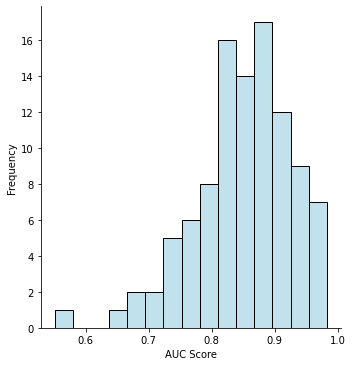

In [93]:
#from the 10 best models, 100 aucs in a histogram
sns.displot(auc_list, bins = 15, color='lightblue')
plt.xlabel('AUC Score')
plt.ylabel('Frequency')
# plt.title('Nested Cross Validation AUC Scores', fontsize = 15)

#median = 0.882
#mean = 0.880
plt.savefig('primary model/primary auc scores')

### generate predictions

In [22]:
#100 iterations using random state and 10 best params
#for each best param, do 10 predictions using random states

data = original_clean
param_dict = sorted(param_top_ten, key = lambda x: x[1])[-10:]
prediction_matrix = pd.DataFrame(original_clean.reset_index()['species'])  
models_list_proven = []

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': int(param_dict[x][0]['n_estimators']),
                              'scale_pos_weight': int(param_dict[x][0]['scale_pos_weight']), 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    
    for u in range(10):
        X, y = data.iloc[:,:-1], data.iloc[:,-1]
        #stratify to make sure the 1s are distributed evenly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
        
        model = XGBClassifier(**params, booster='gbtree', objective='binary:logistic', eval_metric = 'logloss', use_label_encoder=False)
        model.fit(X_train, y_train)
        
        models_list_proven.append(model)

        #predictions in an array
        y = model.predict_proba(X)

        #match prediction to the species for this split
        probability_table = X.reset_index() #get the species in the test set
        probability_table['probability'] = pd.DataFrame(pd.DataFrame(y)[1]) #get the probabilities
        probability_table = probability_table[['species', 'probability']]
        #put the prediction in the big df
        for a in range(len(prediction_matrix)):
            for b in range(len(probability_table)):
                if prediction_matrix.loc[a, 'species'] == probability_table.loc[b, 'species']:
                    prediction_matrix.loc[a, str(x) + '.' + str(u)] = probability_table.loc[b, 'probability']

C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use s

C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use s

C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use s

In [24]:
#get a prediction table with the median probability and percentile for each species
prediction_matrix['std'] = pd.DataFrame(prediction_matrix.std(axis=1))
prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.median(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)

#these are the sandflies where the probability its a vector is greater than 0.5
#top_predictions = top_predictions[top_predictions['probability'] >= 0.5].reset_index(drop=True)

#get the important stats only
top_predictions = top_predictions[['species', 'probability','std', 'percentile']].reset_index(drop=True)

#add real labels
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)

#sort by probability
final_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
final_predictions = final_predictions.round(3)
final_predictions

C:\Users\GARLIC~1\AppData\Local\Temp/ipykernel_13036/479781312.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  prediction_matrix['std'] = pd.DataFrame(prediction_matrix.std(axis=1))
C:\Users\GARLIC~1\AppData\Local\Temp/ipykernel_13036/479781312.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.median(axis=1))


,species,probability,std,percentile,potential/proven
0,Bichromomyia flaviscutellata,0.959,0.079,1.000,2.0
1,Nyssomyia whitmani,0.936,0.087,0.998,2.0
2,Psychodopygus davisi,0.932,0.082,0.996,2.0
3,Psychodopygus carrerai,0.932,0.086,0.993,2.0
4,Nyssomyia intermedia,0.932,0.089,0.993,2.0
...,...,...,...,...,...
507,Evandromyia (Evandromyia) wilsoni,0.033,0.069,0.009,0.0
508,Evandromyia (Barrettomyia) costalimai,0.033,0.069,0.009,0.0
509,Micropygomyia (Sauromyia) ferreirana,0.033,0.088,0.006,1.0
510,Micropygomyia (Micropygomyia) pilosa,0.033,0.069,0.003,0.0


In [25]:
#save the final predictions
final_predictions.to_csv("primary model/primary predictions.csv")

In [211]:
#get the proportions for the figure
final_predictions[final_predictions['potential/proven']!=2].head(26)
#how many non vectors did it predict to be a vector?
#len(d[d['probability'] >= 0.5]) = 13

,species,probability,std,percentile,potential/proven
16,Psychodopygus amazonensis,0.868,0.122,0.969,1.0
19,Nyssomyia antunesi,0.852,0.122,0.963,1.0
22,Psychodopygus claustrei,0.838,0.109,0.957,0.0
32,Psychodopygus guyanensis,0.748,0.133,0.938,0.0
33,Pintomyia (Pintomyia) pessoai,0.739,0.199,0.936,1.0
36,Psathyromyia (Psathyromyia) bigeniculata,0.725,0.150,0.930,0.0
37,Trichophoromyia auraensis,0.702,0.195,0.928,1.0
40,Psychodopygus chagasi,0.592,0.205,0.922,0.0
41,Trichophoromyia castanheirai,0.584,0.213,0.920,0.0
42,Sciopemyia sordellii,0.578,0.186,0.918,1.0


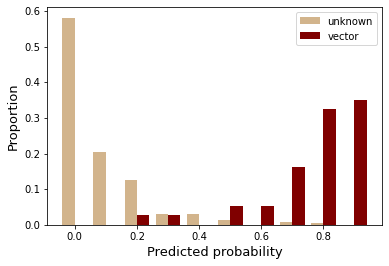

In [199]:
#make a histogram of predicted probabilities, scaled by proportion, like in han et al 2019
nonconfirmed_probs = final_predictions[final_predictions['potential/proven']!=2]['probability']
#found these values by hand
nonconfirmed_hist = [276., 97.,  60.,  15.,  14.,  6.,   0.,   4.,   3.,   0.]
confirmed_hist = [0.,  0.,  1.,  1.,  0.,  2.,  2.,  6.,  12., 13.]
nonconfirmed_hist = nonconfirmed_hist/np.sum(nonconfirmed_hist)
confirmed_hist = confirmed_hist/np.sum(confirmed_hist)

fig = plt.figure()
ax = plt.subplot(111)

width = 0.04
x = np.arange(0, 1, 0.1)
plt.bar(x-width/2, nonconfirmed_hist, width = width, color = 'tan')
plt.bar(x+width/2, confirmed_hist, width = width, color = 'maroon')

plt.legend(["unknown", "vector"], loc ="upper right")
plt.xlabel('Predicted probability', size = 13)
plt.ylabel('Proportion', size = 13)
plt.savefig('primary model/probability distribution')

### predictions to tables

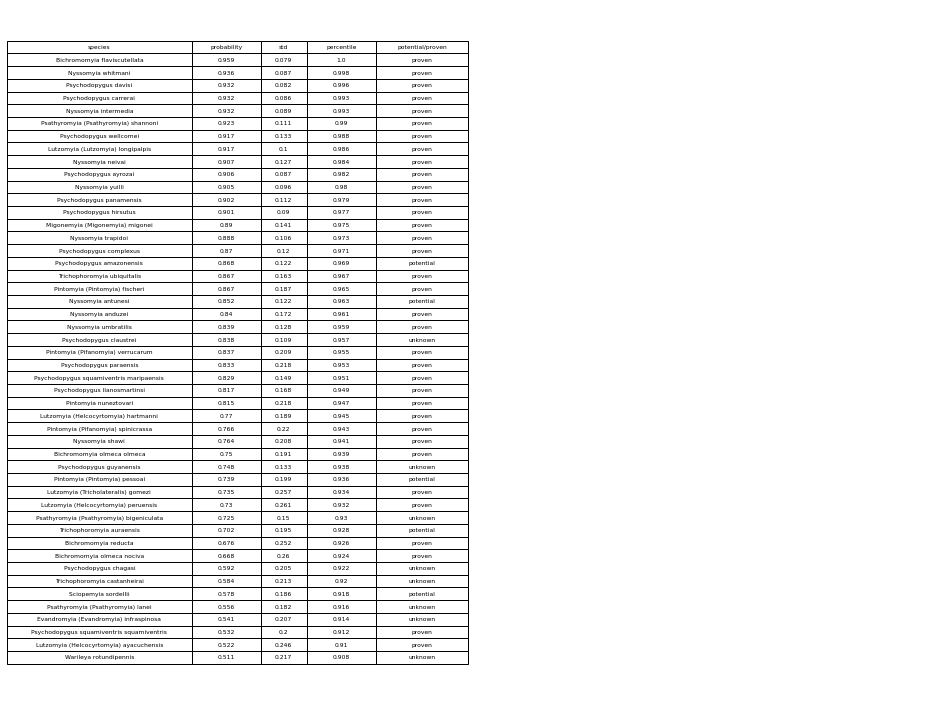

In [212]:
from matplotlib.backends.backend_pdf import PdfPages
fig, ax =plt.subplots(figsize=(8,12))
# ax.axis('tight')
ax.axis('off')
top_predictions = final_predictions.head(48) #these are the sandflies with above 0.5 

#reqrite the infection status columns
top_predictions.loc[top_predictions['potential/proven'] == 1.0, 'potential/proven'] = 'potential'
top_predictions.loc[top_predictions['potential/proven'] == 2.0, 'potential/proven'] = 'proven'
top_predictions.loc[top_predictions['potential/proven'] == 0.0, 'potential/proven'] = 'unknown'

the_table = ax.table(cellText=top_predictions.values,colLabels=top_predictions.columns,loc='left', cellLoc = 'center',
                     colWidths=[0.4, 0.15, 0.1, 0.15, 0.2])


#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("primary model/top 48 predictions.pdf")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [30]:
#get the nonvector sandflies
#rewrite the infection status column
non_proven_predictions = final_predictions[final_predictions['potential/proven'] != 2].reset_index(drop=True)
non_proven_predictions.loc[non_proven_predictions['potential/proven'] == 1.0, 'potential/proven'] = 'potential'
non_proven_predictions.loc[non_proven_predictions['potential/proven'] == 2.0, 'potential/proven'] = 'proven'
non_proven_predictions.loc[non_proven_predictions['potential/proven'] == 0.0, 'potential/proven'] = 'unknown'
non_proven_predictions.rename(columns = {'potential/proven':'infection status'}, inplace = True)
non_proven_predictions = non_proven_predictions[['species', 'probability', 'std', 'percentile', 'infection status']]

In [32]:
#get only the predicted ones above probability 0.5
non_proven_top = non_proven_predictions[non_proven_predictions['probability'] >= 0.5]

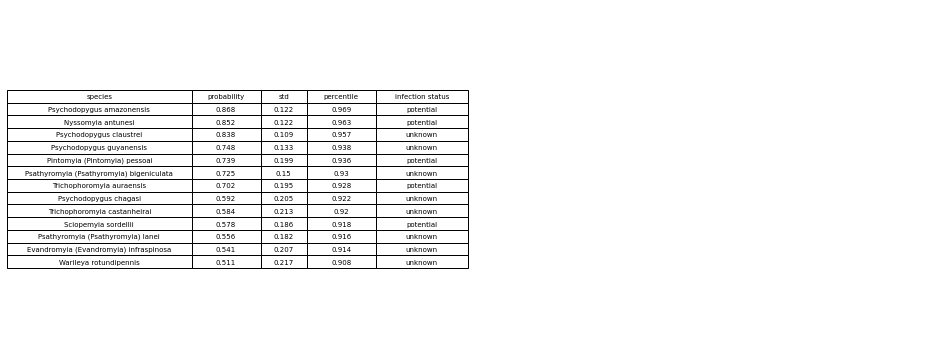

In [35]:
from matplotlib.backends.backend_pdf import PdfPages

fig, ax =plt.subplots(figsize=(8,6))
# ax.axis('tight')
ax.axis('off')

the_table = ax.table(cellText=non_proven_top.values,colLabels=non_proven_top.columns,loc='left', cellLoc = 'center',
                     colWidths=[0.4, 0.15, 0.1, 0.15, 0.2])

pp = PdfPages("primary model/non proven top predictions.pdf")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [37]:
non_proven_predictions.to_csv("primary model/non proven predictions.csv")

### variable importance

In [58]:
#takes in modelslist created in the predtable function, returns dataframe of variables and importances
def var_impt(list_of_models):

    impt_matrix = pd.DataFrame(list_of_models[0].feature_importances_, original_clean.columns[0:81])
    for x in range(1, len(list_of_models)):
        var_array = pd.DataFrame(list_of_models[x].feature_importances_, original_clean.columns[0:81])
        impt_matrix[x] = var_array[0]
        
    var_impt_df = pd.DataFrame()
    var_impt_df['feature'] = original_clean.columns[0:81]
    var_impt_df = var_impt_df.set_index('feature')
    for var in original_clean.columns[0:81]:
        mean = impt_matrix.loc[var].mean()
        var_impt_df.loc[var, 'importance'] = mean
        std = impt_matrix.loc[var].std()
        var_impt_df.loc[var, 'std'] = std

    var_impt_df = var_impt_df.reset_index()
    
    return impt_matrix, var_impt_df.round(3).sort_values(by='importance', ascending=False)

In [79]:
var_impt_conf = var_impt(models_list_proven)[1]
var_impt_conf['lower'] = var_impt_conf['importance'] - 1.96 * var_impt_conf['std'] / 10
var_impt_conf['higher'] = var_impt_conf['importance'] + 1.96 * var_impt_conf['std'] / 10

In [256]:
var_impt_conf.reset_index(drop=True).to_csv("primary model/variable importance 82.csv")

In [240]:
var_impt_conf = pd.read_csv("primary model/variable importance 82.csv")
var_impt_conf.head(20)

,feature,importance,std,lower,higher
0,log(citations),0.218,0.132,0.192128,0.243872
1,log(ecoregion breadth),0.092,0.105,0.071420,0.112580
2,canopy height,0.071,0.106,0.050224,0.091776
3,Bichromomyia genus,0.047,0.031,0.040924,0.053076
4,temperature range,0.045,0.036,0.037944,0.052056
5,Pintomyia genus,0.042,0.034,0.035336,0.048664
6,semidomestic,0.038,0.061,0.026044,0.049956
7,global human modification,0.036,0.052,0.025808,0.046192
8,number of lateral teeth,0.032,0.030,0.026120,0.037880
9,log(rainfall),0.032,0.042,0.023768,0.040232


In [241]:
'''
citations - red
morphology - lightblue
taxonomy - grey
biogeography/ecology - lightgreen
'''
c = 'red'
m = 'deepskyblue'
t = 'black'
b = 'limegreen'
color_list = [c, b, b, t, b,
             t, b, b, m, b,
              b, b, b, m, t,
              b, b, b, b, b]


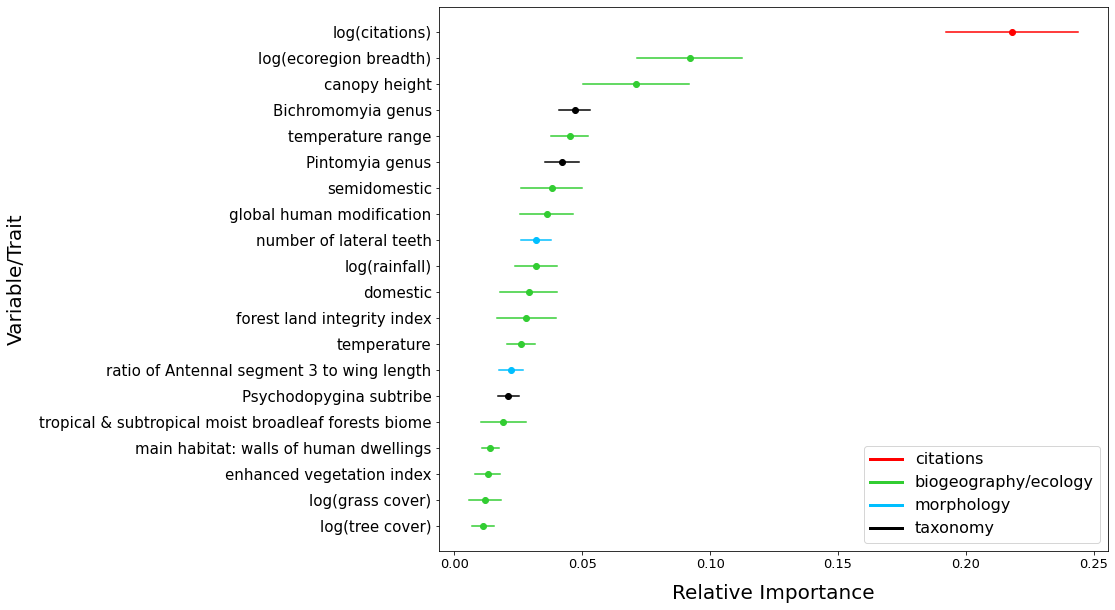

In [242]:
# for the top 10, with categorical variables summed:
fig, ax = plt.subplots()

# plot the importances with their confidence intervals
x = var_impt_conf.head(20)['feature'].to_list()
y = var_impt_conf.head(20)['importance'].to_list()

for num in range(20):
    plt.scatter(y[num], x[num], c = color_list[num])
# plt.scatter(y, x, c = "lightgrey")
plt.yticks(fontsize=15)
plt.xticks(fontsize=13)

#plot the lower and upper confidence interval
for lower,upper,y in zip(var_impt_conf['lower'].head(20), var_impt_conf['higher'].head(20),
                         range(len(color_list))):
    plt.plot((lower,upper),(y,y), color=color_list[y])

#fix the axes naming and size
plt.rcParams["figure.figsize"] = (12,10)
plt.xlabel("Relative Importance", labelpad=13, fontsize = 20)
plt.ylabel('Variable/Trait', labelpad = 13, fontsize = 20)
plt.rc('axes', titlesize=20) #axes font size
plt.gca().invert_yaxis()

from matplotlib.lines import Line2D
#plot the legend
custom_lines = [Line2D([0], [0], color='red', lw=3),
                Line2D([0], [0], color='limegreen', lw=3),
                Line2D([0], [0], color='deepskyblue', lw=3),
               Line2D([0], [0], color='black', lw=3)]
#give the legend lines names
ax.legend(custom_lines, ['citations', 'biogeography/ecology', 'morphology', 'taxonomy'],
          loc = 'lower right', fontsize = 16)

plt.savefig('primary model/top 20 features scatterplot.png', bbox_inches='tight')

### summing the categorical variables

In [93]:
#from this variable importance dataframe, we can sum up the categorical variables into a new dataframe. i did this by hand:
var_impt_sum = pd.read_csv("primary model/variable importance sum.csv")

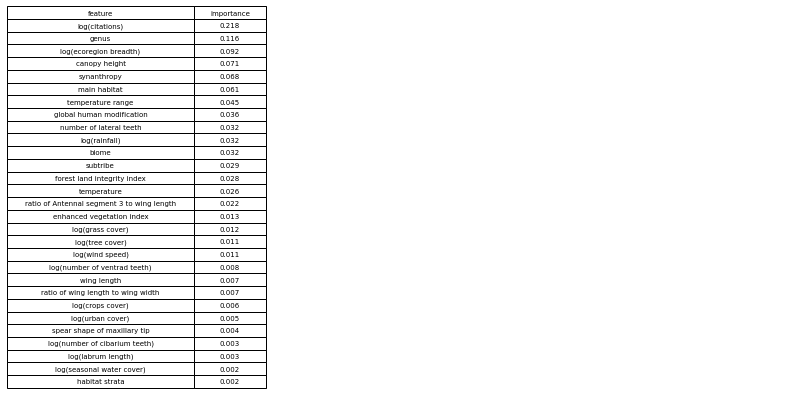

In [99]:
#for the table, get only the feature and importance
var_impt_sum_1 = var_impt_sum[['feature', 'importance']]

fig, ax =plt.subplots(figsize=(9,6))
# ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=var_impt_sum_1.values,colLabels=var_impt_sum_1.columns,loc='left', cellLoc = 'center',
                     colWidths=[0.36, 0.14, 0.1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(7)


#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("primary model/variable importance sum.pdf")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [244]:
'''
citations - red
morphology - lightblue
taxonomy - grey
biogeography/ecology - lightgreen
'''
c = 'red'
m = 'deepskyblue'
t = 'black'
b = 'limegreen'
color_list_2 = [c, t, b, b, b, b, b, b, m, b]

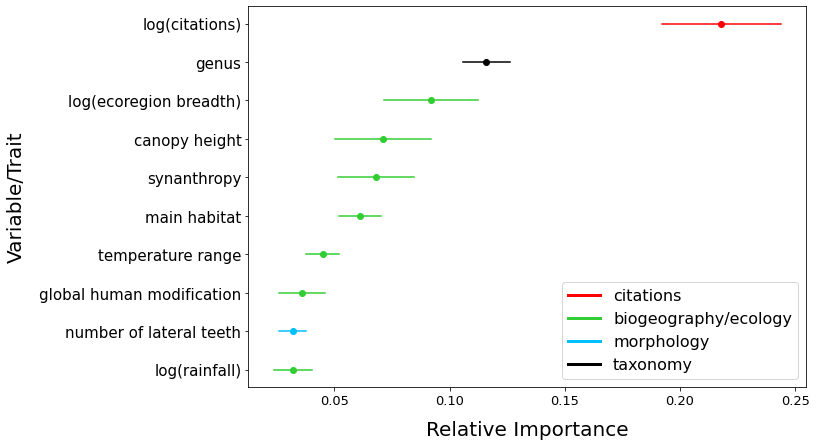

In [247]:
# for the top 10, with categorical variables summed:
fig, ax = plt.subplots()

# plot the importances with their confidence intervals
x = var_impt_sum.head(10)['feature'].to_list()
y = var_impt_sum.head(10)['importance'].to_list()

for num in range(len(color_list_2)):
    plt.scatter (y[num], x[num], c = color_list_2[num])
# plt.scatter(y, x, c = "lightgrey")
plt.yticks(fontsize=15)
plt.xticks(fontsize=13)

#plot the lower and upper confidence interval
for lower,upper,y in zip(var_impt_sum['lower'].head(10), var_impt_sum['higher'].head(10),
                         range(len(var_impt_sum))):
    plt.plot((lower,upper),(y,y), color=color_list_2[y])

#fix the axes naming and size
plt.rcParams["figure.figsize"] = (10,7)
plt.xlabel("Relative Importance", labelpad=13, fontsize = 20)
plt.ylabel('Variable/Trait', labelpad = 13, fontsize = 20)
plt.rc('axes', titlesize=20) #axes font size
plt.gca().invert_yaxis()

#plot the legend
custom_lines = [Line2D([0], [0], color='red', lw=3),
                Line2D([0], [0], color='limegreen', lw=3),
                Line2D([0], [0], color='deepskyblue', lw=3),
               Line2D([0], [0], color='black', lw=3)]
#give the legend lines names
ax.legend(custom_lines, ['citations', 'biogeography/ecology', 'morphology', 'taxonomy'],
          loc = 'lower right', fontsize = 16)

plt.savefig('primary model/top 10 summed features scatterplot.png', bbox_inches='tight')

### partial dependence plots

In [145]:
data = original_clean
X, y = data.iloc[:,:-1], data.iloc[:,-1]
data.to_csv("primary model/partial dependence/trait data.csv")

In [ ]:
### this theoretically should work, but for some reason, the partial dependence plots of some variables are blank
### and their partial dependence numbers have a list of nans
### for this reason, i collected the yhat lists in R, and am going to use that data to plot the graphs

fig = plt.figure()
ax = plt.subplot(111)

model_type = models_list_proven
color = 'lightgreen'
a = 0

variable = var_impt_conf.loc[a, 'feature']

model0_plot = PartialDependenceDisplay.from_estimator(model_type[0], X, [variable], ax=ax,  line_kw={"color": color})
for x in range(1, 100):
    model_plot = PartialDependenceDisplay.from_estimator(model_type[x], X, [variable],
                                                         ax=model0_plot.axes_,  line_kw={"color": color})

plt.ylim((0.0,0.4))

#get average line
ax = plt.gca()
line = ax.lines[0]
x_array = line.get_xdata()

y_array = ax.lines[0].get_ydata()
for i in range(1, 100):
    y_array += ax.lines[i].get_ydata()
y_array = y_array/100
fig.set_size_inches(4, 2)
plt.xlabel('')
plt.title(variable)
plt.plot(x_array, y_array, color = 'black')

# #histogram behind
# ax2 = ax.twinx()
# df_var = og['citations'].to_list()
# histogram = plt.hist(df_var, range=(0, 1), color = 'lightgrey', bins = 5, alpha = 0.4)

In [2]:
##load all the csvs
Bichromomyia = pd.read_csv('primary model/partial dependence data/Bichromomyia.csv')
Pintomyia = pd.read_csv('primary model/partial dependence data/Pintomyia.csv')
domestic = pd.read_csv('primary model/partial dependence data/domestic.csv')
Psychodopygina = pd.read_csv('primary model/partial dependence data/Psychodopygina.csv')
semidomestic = pd.read_csv('primary model/partial dependence data/semidomestic.csv')
b_tsmbf = pd.read_csv('primary model/partial dependence data/b_tsmbf.csv')

#continuous variables - rows are not the same length, so we add a names parameter
citations = pd.read_csv('primary model/partial dependence data/citations.csv', names=list(range(27)))
canopy = pd.read_csv('primary model/partial dependence data/canopy.csv', names=list(range(pd.read_csv('primary model/partial dependence data/canopy.csv').shape[1])))
ecoregion = pd.read_csv('primary model/partial dependence data/ecoregion.csv', names=list(range(17)))
rainfall = pd.read_csv('primary model/partial dependence data/rainfall.csv', names=list(range(pd.read_csv('primary model/partial dependence data/rainfall.csv').shape[1])))
ghm = pd.read_csv('primary model/partial dependence data/ghm.csv', names=list(range(pd.read_csv('primary model/partial dependence data/ghm.csv').shape[1])))
flii = pd.read_csv('primary model/partial dependence data/flii.csv', names=list(range(pd.read_csv('primary model/partial dependence data/flii.csv').shape[1])))
lateral = pd.read_csv('primary model/partial dependence data/lateral.csv', names=list(range(36)))
temprange = pd.read_csv('primary model/partial dependence data/temprange.csv', names=list(range(pd.read_csv('primary model/partial dependence data/temprange.csv').shape[1])))
temp = pd.read_csv('primary model/partial dependence data/temp.csv', names=list(range(pd.read_csv('primary model/partial dependence data/temp.csv').shape[1])))
A3_wingl = pd.read_csv('primary model/partial dependence data/A3_wingl.csv', names=list(range(12)))

In [3]:
#binary variables
binary_df = [Bichromomyia, Pintomyia, domestic, semidomestic, Psychodopygina, b_tsmbf]
#cont variables with same length rows
variable_dfs_1 = [canopy, rainfall, ghm, flii, temprange, temp]
#cont variables with not same length rows
variable_dfs_2 = [citations, ecoregion, lateral, A3_wingl]

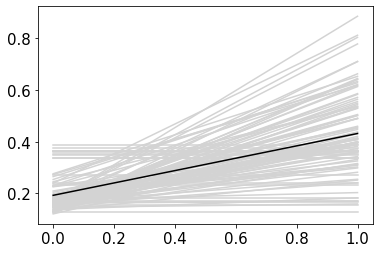

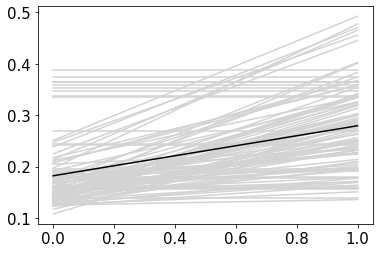

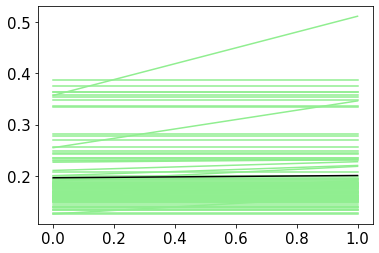

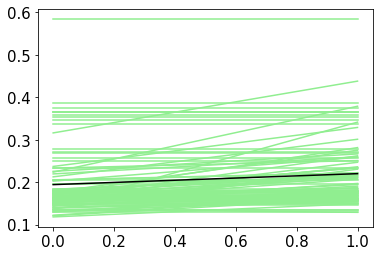

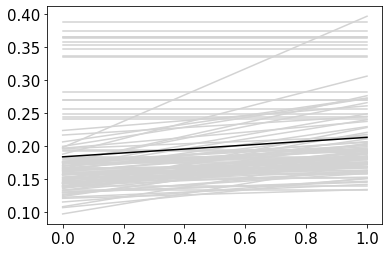

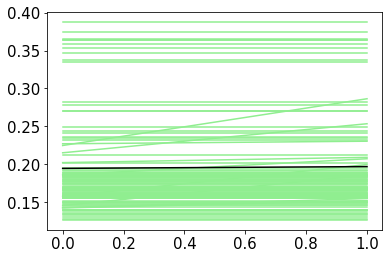

In [31]:
#binary variables
'''
citations - red
morphology - lightblue
taxonomy - grey
biogeography/ecology - lightgreen
'''
c = 'red'
m = 'deepskyblue'
t = 'lightgrey'
b = 'lightgreen'
colors_list = [t, t, b, b, t, b]
# colors_list = ['lightgrey', 'lightgrey', 'lightgreen', 'lightgreen', 'lightgrey', 'lightgrey', 'lightgreen']
for d in range(len(binary_df)):
    fig = plt.figure()
    ax = plt.subplot(111)
    
    color = colors_list[d]
    data = binary_df[d].iloc[:,1:]
    x_axis = data.iloc[:,0]
    
    for x in range(100):
        y_axis = data.iloc[:,x*2+1]
        modelx_plot = plt.plot(x_axis,y_axis, color = color)
        
    #get average line
    ax = plt.gca()
    line = ax.lines[0]
    x_array = line.get_xdata()

    y_array = ax.lines[0].get_ydata()
    for i in range(1, 100):
        y_array += ax.lines[i].get_ydata()
    y_array = y_array/100
    plt.plot(x_array, y_array, color = 'black')   
        
#     plt.xlabel(data.iloc[:,[0]].columns[0])
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.rcParams["figure.figsize"] = (6,4)

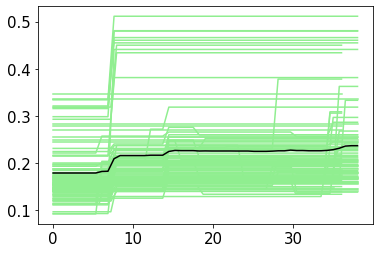

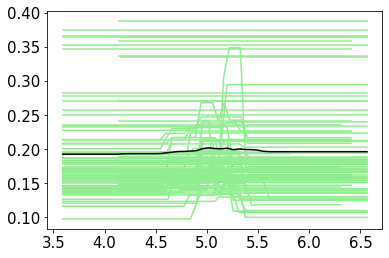

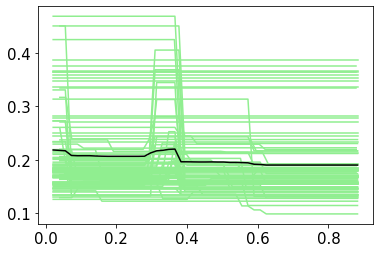

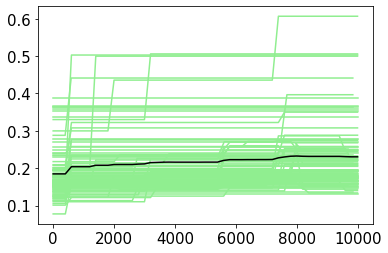

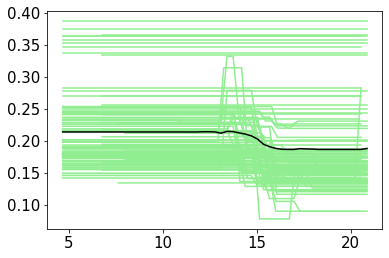

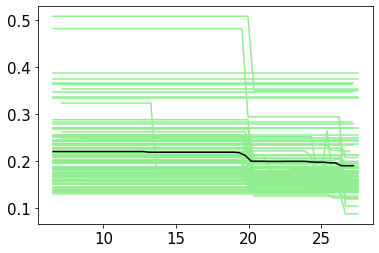

In [4]:
#continuous variables part 1
#canopy, rainfall, ghm, flii, temprange, temp

'''
citations - red
morphology/genus - black
biogeo/ecology - green
'''

for df in variable_dfs_1:
    fig = plt.figure()
    ax = plt.subplot(111)
        
    data = df
    color = 'lightgreen'
    
    for x in range(100):
        x_axis = data.loc[x*2].dropna()[1:]
        y_axis = data.loc[x*2+1].dropna()[1:]
        modelx_plot = plt.plot(x_axis,y_axis, color = color)
        
    #get average line
    ax = plt.gca()
    line = ax.lines[0]
    x_array = line.get_xdata()

    y_array = ax.lines[0].get_ydata()
    for i in range(1, 100):
        y_array += ax.lines[i].get_ydata()
    y_array = y_array/100
    plt.plot(x_array, y_array, color = 'black')

#     plt.xlabel(data.loc[0][0])
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.rcParams["figure.figsize"] = (6,4)

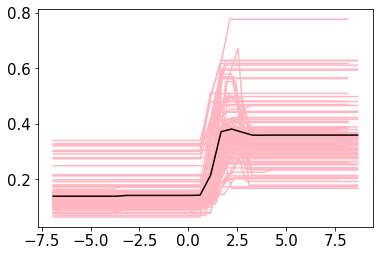

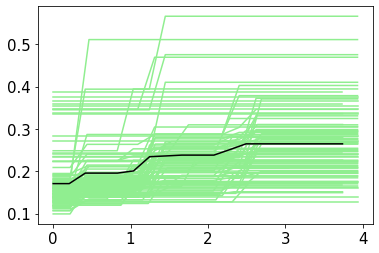

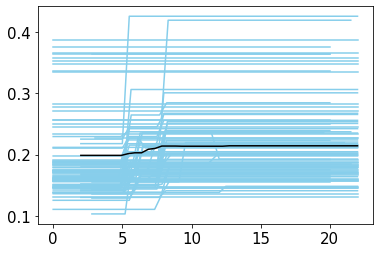

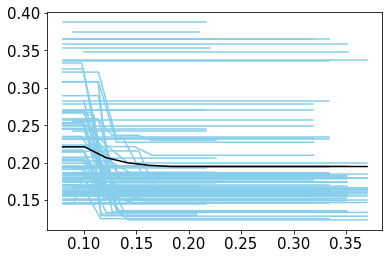

In [81]:
#continuous variables part 2
#citations, ecoregion, lateral, A3_wingl
'''
citations - red
morphology - lightblue
taxonomy - grey
biogeography/ecology - lightgreen
'''
c = 'lightpink'
m = 'deepskyblue'
t = 'black'
b = 'limegreen'
colors_list = ['lightpink', 'lightgreen', 'skyblue', 'skyblue']

for d in range(len(variable_dfs_2)):
    fig = plt.figure()
    ax = plt.subplot(111)

    data = variable_dfs_2[d].reset_index(drop=False)
    data.columns = range(data.columns.size)
    color = colors_list[d]

    for x in range(100):
        x_axis = data.loc[x*2].dropna()[1:]
        y_axis = data.loc[x*2+1].dropna()[1:]
        modelx_plot = plt.plot(x_axis,y_axis, color = color)

    length_list = []
    for x in range(100):
        length = len(data.loc[x*2].dropna()[1:])
        length_list.append(length)
    median_length = round(np.median(length_list))

    median_df = pd.DataFrame()
    for x in range(100):
        if len(data.loc[x*2].dropna()[1:])==median_length:
            median_df = median_df.append(data.loc[x*2].dropna()) 
            median_df = median_df.append(data.loc[x*2 + 1].dropna()) 

    median_df = median_df.reset_index(drop=True)
    median_df = median_df.iloc[:, 1:]
    x_ax = median_df.iloc[0]
    mean_df = pd.DataFrame()
    for i in range(len(median_df)//2):
        mean_df = mean_df.append(median_df.iloc[2*i + 1],ignore_index=True)

    y_avg = mean_df.mean(axis=0)

    plt.plot(x_ax, y_avg, color = 'black')


    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.rcParams["figure.figsize"] = (6,4)


# get the lat/long coords of predicted vectors

In [159]:
# vector latlong
latlong = pd.read_csv("raw data/latlong.csv")

vector_latlong = latlong[latlong['scientificName'].isin(list(status['species']))].drop_duplicates()
vector_latlong = vector_latlong.reset_index(drop = True)

In [163]:
vector_latlong.to_csv("occurrence data/vector_latlong.csv")

In [258]:
# predicted vector latlong
predicted_latlong = latlong[latlong['scientificName'].isin(list(non_proven_top['species']))].drop_duplicates()
predicted_latlong = predicted_latlong.reset_index(drop = True)

In [260]:
predicted_latlong.to_csv("occurrence data/predicted_latlong.csv")